# **Lab 3: GPU Memory**

This lab gives a closer eye into the GPU memory hierarchy, elaborates how the shared memory is very powerful, provides an active case study of matrix multiplication.

### **Recall: Memory Hierarchy**

CUDA threads may access data from multiple memory spaces during their execution as illustrated below. Each thread has private local memory, and also a shared memory visible to all threads of the block and with the same lifetime as the block. All threads have access to the same global memory.

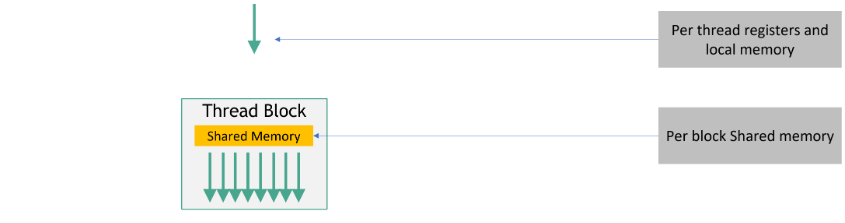

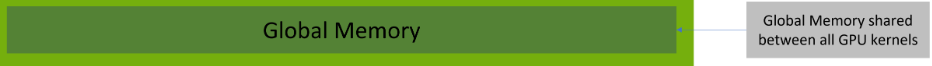

### **Shared Memory**

Because it is on-chip, shared memory is much faster than local and global memory. In fact, shared memory latency is roughly 100x lower than uncached global memory latency. Shared memory is allocated per thread block, so all threads in the block have access to the same shared memory. Threads can access data in shared memory loaded from global memory by other threads within the same thread block. This has multiple use-cases such as user-managed data caches, high-performance cooperative parallel algorithms (parallel reductions, for example), and to facilitate global memory coalescing.

*There are multiple ways to declare shared memory inside a kernel, depending on whether the amount of memory is known at compile time or at run time as illustrated below*

In [ ]:
#include

__global__ void static(int *d, int n)
{
  __shared__ int s[64];
  int t = threadIdx.x;
  int tr = n-t-1;
  s[t] = d[t];
  __syncthreads();
  d[t] = s[tr];
}

__global__ void dynamic(int *d, int n)
{
  extern __shared__ int s[];
  int t = threadIdx.x;
  int tr = n-t-1;
  s[t] = d[t];
  __syncthreads();
  d[t] = s[tr];
}

int main(void)
{
  const int n = 64;
  int a[n], r[n], d[n];

  for (int i = 0; i < n; i++) {
    a[i] = i;
    r[i] = n-i-1;
    d[i] = 0;
  }

  int *d_d;
  cudaMalloc(&d_d, n * sizeof(int));

  // run version with static shared memory
  cudaMemcpy(d_d, a, n*sizeof(int), cudaMemcpyHostToDevice);
  staticReverse<<<1,n>>>(d_d, n);
  cudaMemcpy(d, d_d, n*sizeof(int), cudaMemcpyDeviceToHost);
  for (int i = 0; i < n; i++)
    if (d[i] != r[i]) printf("Error: d[%d]!=r[%d] (%d, %d)n", i, i, d[i], r[i]);

  // run dynamic shared memory version
  cudaMemcpy(d_d, a, n*sizeof(int), cudaMemcpyHostToDevice);
  dynamicReverse<<<1,n,n*sizeof(int)>>>(d_d, n);
  cudaMemcpy(d, d_d, n * sizeof(int), cudaMemcpyDeviceToHost);
  for (int i = 0; i < n; i++)
    if (d[i] != r[i]) printf("Error: d[%d]!=r[%d] (%d, %d)n", i, i, d[i], r[i]);
}

*The two kernels are very similar, differing only in how the shared memory arrays are declared and how the kernels are invoked.*

The reason shared memory is used in this example is to facilitate global memory coalescing on older CUDA devices (Compute Capability 1.1 or earlier). Optimal global memory coalescing is achieved for both reads and writes because global memory is always accessed through the linear, aligned index t. The reversed index tr is only used to access shared memory, which does not have the sequential access restrictions of global memory for optimal performance. The only performance issue with shared memory is bank conflicts. Note that on devices of Compute Capability 1.2 or later, the memory system can fully coalesce even the reversed index stores to global memory. But this technique is still useful for other access patterns

#### **Dynamic Shared Memory**

Can be used when the amount of shared memory is not known at compile time. In this case the shared memory allocation size per thread block must be specified (in bytes) using an optional third execution configuration parameter, as follows:

*dynamicReverse<<<1, n, n* * *sizeof(int)>>>(d_d, n)*

What if you need multiple dynamically sized arrays in a single kernel? You must declare a single extern unsized array as before, and use pointers into it to divide it into multiple arrays, as follows:

In [ ]:
extern __shared__ int s[];
int *integerData = s;                        // nI ints
float *floatData = (float*)&integerData[nI]; // nF floats
char *charData = (char*)&floatData[nF];      // nC chars

// In the kernel launch, specify the total shared memory needed:
myKernel<<<gridSize, blockSize, nI*sizeof(int)+nF*sizeof(float)+nC*sizeof(char)>>>(...);

### **Matrix Multiplication Case Study**

The following 2 code cells illustrate the power of using shared memory in the matrix multiplication problem. The first implementation does not use any shared memory, wheares the second one does.

In [ ]:
// This code does not utilize shared memory

// Matrices are stored in row-major order:
// M(row, col) = *(M.elements + row * M.width + col)
typedef struct {
    int width;
    int height;
    float* elements;
} Matrix;

// Thread block size
#define BLOCK_SIZE 16

// Forward declaration of the matrix multiplication kernel
__global__ void MatMulKernel(const Matrix, const Matrix, Matrix);

// Matrix multiplication - Host code
// Matrix dimensions are assumed to be multiples of BLOCK_SIZE
void MatMul(const Matrix A, const Matrix B, Matrix C)
{
    // Load A and B to device memory
    Matrix d_A;
    d_A.width = A.width; d_A.height = A.height;
    size_t size = A.width * A.height * sizeof(float);
    cudaMalloc(&d_A.elements, size);
    cudaMemcpy(d_A.elements, A.elements, size,
               cudaMemcpyHostToDevice);
    Matrix d_B;
    d_B.width = B.width; d_B.height = B.height;
    size = B.width * B.height * sizeof(float);
    cudaMalloc(&d_B.elements, size);
    cudaMemcpy(d_B.elements, B.elements, size,
               cudaMemcpyHostToDevice);

    // Allocate C in device memory
    Matrix d_C;
    d_C.width = C.width; d_C.height = C.height;
    size = C.width * C.height * sizeof(float);
    cudaMalloc(&d_C.elements, size);

    // Invoke kernel
    dim3 dimBlock(BLOCK_SIZE, BLOCK_SIZE);
    dim3 dimGrid(B.width / dimBlock.x, A.height / dimBlock.y);
    MatMulKernel<<<dimGrid, dimBlock>>>(d_A, d_B, d_C);

    // Read C from device memory
    cudaMemcpy(C.elements, d_C.elements, size,
               cudaMemcpyDeviceToHost);

    // Free device memory
    cudaFree(d_A.elements);
    cudaFree(d_B.elements);
    cudaFree(d_C.elements);
}

// Matrix multiplication kernel called by MatMul()
__global__ void MatMulKernel(Matrix A, Matrix B, Matrix C)
{
    // Each thread computes one element of C
    // by accumulating results into Cvalue
    float Cvalue = 0;
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;
    for (int e = 0; e < A.width; ++e)
        Cvalue += A.elements[row * A.width + e]
                * B.elements[e * B.width + col];
    C.elements[row * C.width + col] = Cvalue;
}

Each thread reads one row of A and one column of B and computes the corresponding element of C as illustrated in the figure. A is therefore read B.width times from global memory and B is read A.height times.

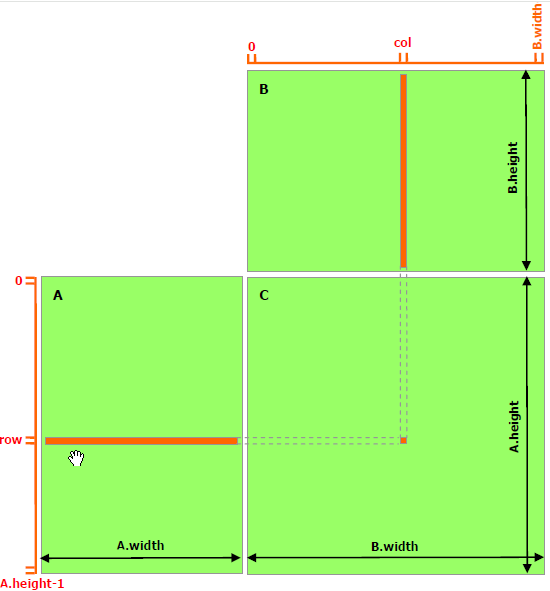

In [ ]:
// This code utilizes shared memory

// Matrices are stored in row-major order:
// M(row, col) = *(M.elements + row * M.stride + col)
typedef struct {
    int width;
    int height;
    int stride;
    float* elements;
} Matrix;
// Get a matrix element
__device__ float GetElement(const Matrix A, int row, int col)
{
    return A.elements[row * A.stride + col];
}
// Set a matrix element
__device__ void SetElement(Matrix A, int row, int col,
                           float value)
{
    A.elements[row * A.stride + col] = value;
}
// Get the BLOCK_SIZExBLOCK_SIZE sub-matrix Asub of A that is
// located col sub-matrices to the right and row sub-matrices down
// from the upper-left corner of A
 __device__ Matrix GetSubMatrix(Matrix A, int row, int col)
{
    Matrix Asub;
    Asub.width    = BLOCK_SIZE;
    Asub.height   = BLOCK_SIZE;
    Asub.stride   = A.stride;
    Asub.elements = &A.elements[A.stride * BLOCK_SIZE * row
                                         + BLOCK_SIZE * col];
    return Asub;
}
// Thread block size
#define BLOCK_SIZE 16
// Forward declaration of the matrix multiplication kernel
__global__ void MatMulKernel(const Matrix, const Matrix, Matrix);
// Matrix multiplication - Host code
// Matrix dimensions are assumed to be multiples of BLOCK_SIZE
void MatMul(const Matrix A, const Matrix B, Matrix C)
{
    // Load A and B to device memory
    Matrix d_A;
    d_A.width = d_A.stride = A.width; d_A.height = A.height;
    size_t size = A.width * A.height * sizeof(float);
    cudaMalloc(&d_A.elements, size);
    cudaMemcpy(d_A.elements, A.elements, size,
               cudaMemcpyHostToDevice);
    Matrix d_B;
    d_B.width = d_B.stride = B.width; d_B.height = B.height;
    size = B.width * B.height * sizeof(float);
    cudaMalloc(&d_B.elements, size);
    cudaMemcpy(d_B.elements, B.elements, size,
    cudaMemcpyHostToDevice);
    // Allocate C in device memory
    Matrix d_C;
    d_C.width = d_C.stride = C.width; d_C.height = C.height;
    size = C.width * C.height * sizeof(float);
    cudaMalloc(&d_C.elements, size);
    // Invoke kernel
    dim3 dimBlock(BLOCK_SIZE, BLOCK_SIZE);
    dim3 dimGrid(B.width / dimBlock.x, A.height / dimBlock.y);
    MatMulKernel<<<dimGrid, dimBlock>>>(d_A, d_B, d_C);
    // Read C from device memory
    cudaMemcpy(C.elements, d_C.elements, size,
               cudaMemcpyDeviceToHost);
    // Free device memory
    cudaFree(d_A.elements);
    cudaFree(d_B.elements);
    cudaFree(d_C.elements);
}
// Matrix multiplication kernel called by MatMul()
 __global__ void MatMulKernel(Matrix A, Matrix B, Matrix C)
{
    // Block row and column
    int blockRow = blockIdx.y;
    int blockCol = blockIdx.x;
    // Each thread block computes one sub-matrix Csub of C
    Matrix Csub = GetSubMatrix(C, blockRow, blockCol);
    // Each thread computes one element of Csub
    // by accumulating results into Cvalue
    float Cvalue = 0;
    // Thread row and column within Csub
    int row = threadIdx.y;
    int col = threadIdx.x;
    // Loop over all the sub-matrices of A and B that are
    // required to compute Csub
    // Multiply each pair of sub-matrices together
    // and accumulate the results
    for (int m = 0; m < (A.width / BLOCK_SIZE); ++m) {
        // Get sub-matrix Asub of A
        Matrix Asub = GetSubMatrix(A, blockRow, m);
        // Get sub-matrix Bsub of B
        Matrix Bsub = GetSubMatrix(B, m, blockCol);
        // Shared memory used to store Asub and Bsub respectively
        __shared__ float As[BLOCK_SIZE][BLOCK_SIZE];
        __shared__ float Bs[BLOCK_SIZE][BLOCK_SIZE];
        // Load Asub and Bsub from device memory to shared memory
        // Each thread loads one element of each sub-matrix
        As[row][col] = GetElement(Asub, row, col);
        Bs[row][col] = GetElement(Bsub, row, col);
        // Synchronize to make sure the sub-matrices are loaded
        // before starting the computation
        __syncthreads();
        // Multiply Asub and Bsub together
        for (int e = 0; e < BLOCK_SIZE; ++e)
            Cvalue += As[row][e] * Bs[e][col];
        // Synchronize to make sure that the preceding
        // computation is done before loading two new
        // sub-matrices of A and B in the next iteration
        __syncthreads();
    }
    // Write Csub to device memoryiemoryi
    // Each thread writes one element
    SetElement(Csub, row, col, Cvalue);
}

In this implementation, each thread block is responsible for computing one square sub-matrix Csub of C and each thread within the block is responsible for computing one element of Csub. As illustrated in the following figure, Csub is equal to the product of two rectangular matrices: the sub-matrix of A of dimension (A.width, block_size) that has the same row indices as Csub, and the sub-matrix of B of dimension (block_size, A.width )that has the same column indices as Csub. In order to fit into the device’s resources, these two rectangular matrices are divided into as many square matrices of dimension block_size as necessary and Csub is computed as the sum of the products of these square matrices. Each of these products is performed by first loading the two corresponding square matrices from global memory to shared memory with one thread loading one element of each matrix, and then by having each thread compute one element of the product. Each thread accumulates the result of each of these products into a register and once done writes the result to global memory.

By blocking the computation this way, we take advantage of fast shared memory and save a lot of global memory bandwidth since A is only read (B.width / block_size) times from global memory and B is read (A.height / block_size) times. The Matrix type from the previous code sample is augmented with a stride field, so that sub-matrices can be efficiently represented with the same type.

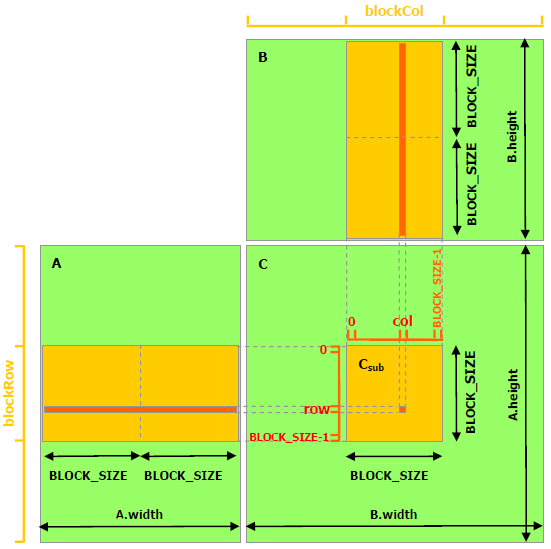

### **Resources**

*   https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#programming-model
*   https://developer.nvidia.com/blog/using-shared-memory-cuda-cc/
